In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

# Kalman Filter Implementation for Constant Velocity Model (CV) in Python

![Image](http://www.cbcity.de/wp-content/uploads/2013/06/Fahrzeug_GPS_Tunnel-520x181.jpg)

Situation covered: You drive with your car in a tunnel and the GPS signal is lost. Now the car has to determine, where it is in the tunnel. The only information it has, is the velocity in driving direction. The x and y component of the velocity ($\dot x$ and $\dot y$) can be calculated from the absolute velocity (revolutions of the wheels) and the heading of the vehicle (yaw rate sensor).

`CC-BY-SA2.0 Lizenz Paul Balzer, Motorblog http://www.cbcity.de` 

![Kalman Filter](Kalman-Filter-Step.png)

First, we have to initialize the matrices and vectors. Setting up the math.

## State Vector

Constant Velocity Model for Ego Motion

$$x_k= \left[ \matrix{ x \\ y \\ \dot x \\ \dot y} \right] = \matrix{ \text{Position X} \\ \text{Position Y} \\ \text{Velocity in X} \\ \text{Velocity in Y}}$$

Formal Definition (Motion of Law):

$$x_{k+1} = \textbf{A} \cdot x_{k}$$

which is

$$x_{k+1} = \begin{bmatrix}1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \end{bmatrix}_{k}$$

Observation Model:

$$y = \textbf{H} \cdot x$$

which is

$$y = \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix} \cdot x$$ means: You observe the velocity directly in the correct unit

### Initial State $x_0$

$$x_{0} = \begin{bmatrix}0 \\ 0 \\ 0 \\ 0\end{bmatrix}$$

In [2]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
#plt.scatter(float(x[0]),float(x[1]), s=100)
#plt.title('Initial Location')

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] (4, 1)


### Initial Uncertainty $P_0$

$$P_{0} = \begin{bmatrix}\sigma^2_x & 0 & 0 & 0 \\ 0 & \sigma^2_y & 0 & 0 \\ 0 & 0 & \sigma^2_{\dot x} & 0 \\ 0 & 0 & 0 & \sigma^2_{\dot y} \end{bmatrix}$$

with $\sigma$ as the standard deviation

In [3]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[ 1000.     0.     0.     0.]
 [    0.  1000.     0.     0.]
 [    0.     0.  1000.     0.]
 [    0.     0.     0.  1000.]] (4, 4)


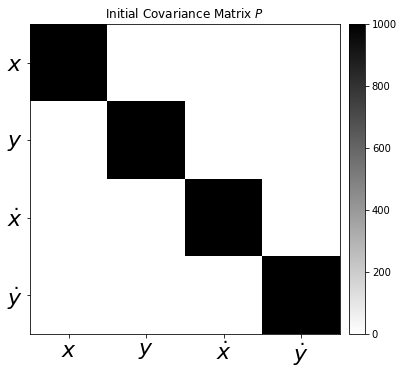

In [4]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

### Dynamic Matrix $A$

It is calculated from the dynamics of the Egomotion.

$$x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t$$
$$y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t$$
$$\dot x_{k+1} = \dot x_{k}$$
$$\dot y_{k+1} = \dot y_{k}$$

In [5]:
dt = 0.1 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[ 1.   0.   0.1  0. ]
 [ 0.   1.   0.   0.1]
 [ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]] (4, 4)


### Measurement Matrix $H$

We directly measure the Velocity $\dot x$ and $\dot y$

$$H = \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$$

In [6]:
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]] (2, 4)


### Measurement Noise Covariance $R$

Tells the Kalman Filter how 'bad' the sensor readings are.

$$R = \begin{bmatrix}\sigma^2_{\dot x} & 0 \\ 0 & \sigma^2_{\dot y} \end{bmatrix}$$

In [7]:
ra = 10.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)

[[ 100.    0.]
 [   0.  100.]] (2, 2)


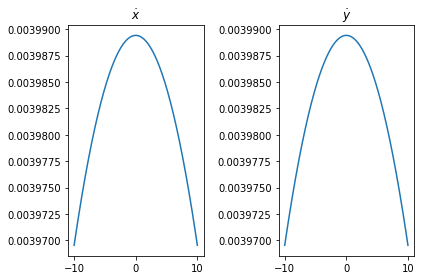

In [8]:
# Plot between -10 and 10 with .001 steps.
xpdf = np.arange(-10, 10, 0.001)
plt.subplot(121)
plt.plot(xpdf, norm.pdf(xpdf,0,R[0,0]))
plt.title('$\dot x$')

plt.subplot(122)
plt.plot(xpdf, norm.pdf(xpdf,0,R[1,1]))
plt.title('$\dot y$')
plt.tight_layout()

### Process Noise Covariance $Q$

The Position of the car can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

$$Q = \begin{bmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{bmatrix}$$

One can calculate Q as

$$Q = G\cdot G^T \cdot \sigma_v^2$$

with $G = \begin{bmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{bmatrix}^T$ and $\sigma_v$ as the acceleration process noise, which can be assumed for a vehicle to be $8.8m/s^2$, according to: Schubert, R., Adam, C., Obst, M., Mattern, N., Leonhardt, V., & Wanielik, G. (2011). [Empirical evaluation of vehicular models for ego motion estimation](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=5940526). 2011 IEEE Intelligent Vehicles Symposium (IV), 534–539. doi:10.1109/IVS.2011.5940526

In [ ]:
sv = 8.8

G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])

Q = G*G.T*sv**2

In [ ]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('dt')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts]])
Qs*Qs.T

In [ ]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

### Identity Matrix $I$

In [ ]:
I = np.eye(4)
print(I, I.shape)

## Measurements

For example, we are using some random generated measurement values

In [ ]:
m = 200 # Measurements
vx= 20 # in X
vy= 10 # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))

measurements = np.vstack((mx,my))

print(measurements.shape)

print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % R[0,0])

In [ ]:
fig = plt.figure(figsize=(16,5))

plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})

In [ ]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))    

# Kalman Filter

![Kalman Filter](Kalman-Filter-Step.png)

In [ ]:
for n in range(len(measurements[0])):
 
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    
    
    # Save states (for Plotting)
    savestates(x, Z, P, R, K)

Thats it.

![Job done](http://www.troll.me/images/the-chuck-norris/job-done.jpg)

# Let's take a look at the filter performance

### Kalman Gains $K$

In [ ]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':22})

In [ ]:
plot_K()

### Uncertainty Matrix $P$

In [ ]:
def plot_P():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Px, label='$x$')
    plt.plot(range(len(measurements[0])),Py, label='$y$')
    plt.plot(range(len(measurements[0])),Pdx, label='$\dot x$')
    plt.plot(range(len(measurements[0])),Pdy, label='$\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

In [ ]:
plot_P()

### State Estimate $x$

In [ ]:
def plot_x():
    fig = plt.figure(figsize=(16,9))
    plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
    plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

    plt.axhline(vx, color='#999999', label='$\dot x_{real}$')
    plt.axhline(vy, color='#999999', label='$\dot y_{real}$')

    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylim([0, 30])
    plt.ylabel('Velocity')

In [ ]:
plot_x()

## Position x/y

In [ ]:
def plot_xy():
    fig = plt.figure(figsize=(16,16))
    plt.scatter(xt,yt, s=20, label='State', c='k')
    plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')

In [ ]:
plot_xy()

# Conclusion

![Nice](http://www.troll.me/images/stifler-thumbs-up/nice.jpg)

It works pretty well. That was basically just dead reckoning, because no position measurement came in.

To use this notebook as a presentation type:

`jupyter-nbconvert --to slides Kalman-Filter-CV.ipynb --reveal-prefix=reveal.js --post serve` 

Questions? [@Balzer82](https://twitter.com/balzer82)